# Mesterséges intelligencia projektfeladat
## Előfeldolgozás
Szükséges python modulok importálása

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# from sklearn.preprocessing import OneHotEncoder

CSV file importálása

In [31]:
df = pd.read_csv(r'../data/202404_hun_mapillary.csv', encoding='utf-8', delimiter=';', low_memory=False)

Az importált adatok ellenőrzése

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143151 entries, 0 to 143150
Data columns (total 46 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          143151 non-null  int64  
 1   geom        143151 non-null  object 
 2   fid         143151 non-null  int64  
 3   cat         143151 non-null  int64  
 4   osm_id      143151 non-null  int64  
 5   access      837 non-null     object 
 6   bicycle     11821 non-null   object 
 7   bridge      4745 non-null    object 
 8   crossing    19059 non-null   float64
 9   highway     143151 non-null  object 
 10  incline     964 non-null     object 
 11  junction    4487 non-null    object 
 12  landuse     124755 non-null  object 
 13  lanes       61967 non-null   float64
 14  leisure     0 non-null       float64
 15  maxspeed    143151 non-null  int64  
 16  maxspeed_t  2142 non-null    object 
 17  maxspeed_f  130 non-null     float64
 18  maxspeed_b  144 non-null     float64
 19  ma

Előzetes adatvizualizáció az adathiányosságok megjelenítéséhez

<Axes: >

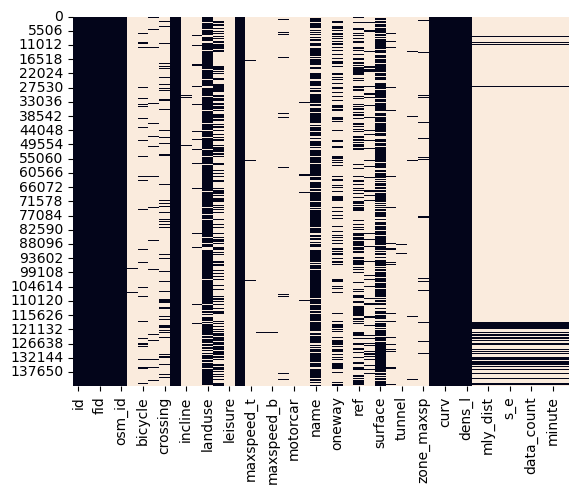

In [33]:
sns.heatmap(df.isnull(), cbar=False)

## Adattisztítás és az adatok további feldolgozása.  
Az egyes attribútumok még nem állnak készen a modell tanításra, ezért megfelelő formára kell őket hozni.  
(A kódok egyáltalán nem egységesek, mert gyakorlásképp igyekeztem minél több dolgot kipróbálni.)   

Megtartandó attribútumok:  
*bicycle, bridge, crossing, oneway,  highway, junction, landuse, lanes, maxspeed, maxweigth, 
motor_vehi, oneway, ref, smoothness, surface, toll, tunnel, width, bua, curv, dens, dens_l, mly_dist, azi, s_e*  
  
Néhány attribútum esetén a boolean típusra való konvertálás tűnt célravezetőnek. Az OpenStreetMap dokumentációnak megfelelően ezeknél az attribútumoknál feltételezhető, hogy akkor is *False* értéknek tekinthezőek, ha egyáltalán nincsenek jelen. Tehát például az explicit *oneway=no* egyenértéknek tekinthető azzal, ha nincs az adott útszegmensnek *oneway* attribútuma. 


In [34]:
mask_bicycle = df["bicycle"].isin(['yes','designated','destination'])
df['bicycle'] = mask_bicycle

mask_bridge = ~(df["bridge"].isin(['no',np.nan]))
df['bridge'] = mask_bridge

df['lanes'].fillna(0, inplace=True)

df['oneway'].replace({'yes': True, 'reversible': True}, inplace=True)
mask_oneway = (df['oneway'].isin([True]))
df['oneway'] = mask_oneway

mask_junction = df["junction"].isin(['roundabout','circular'])
df['junction'] = mask_junction

mask_tunnel = df["tunnel"].isin(['yes','building_passage'])
df['tunnel'] = mask_tunnel

df['toll'] = df['toll'].replace({'yes': 1, 'no': 0})
df['toll'] = df['toll'].fillna(0)
df['toll'] = df['toll'].astype(int)

df['crossing'] = df['crossing'].fillna(0)


Egyéb attribútumoknál a hiányzó/NULL értékeket kell feltölteni valahohgy. Ahol eleve szám a változó és feltételezhető a NULL érték jelentése, ott fel lehet tölteni egy defaultértékkel. Ilyen például a sávok száma ahol a *lanes* attribútum hiánya 1-et jelent. 

In [35]:
df['lanes'].fillna(1, inplace=True)

Egyes kategóriákat jellemző attribútumoknál érdemes egyszerűsíteni az adatokat. Például kiszűrni azokat a kategóriákat amelyekből kevesebb mind 10 vagy 100 rekord van az egész adathalmazban. 

In [36]:
value_maxweight_counts = df['maxweight'].value_counts()
valid_maxweight_values = value_maxweight_counts[value_maxweight_counts >= 10].index
# Fill nan with 0. Probably not good, but better than nothing
df.loc[~df['maxweight'].isin(valid_maxweight_values), 'maxweight'] = 0

value_landuse_counts = df['landuse'].value_counts()
valid_landuse_values = value_landuse_counts[value_landuse_counts >= 100].index
df.loc[~df['landuse'].isin(valid_landuse_values), 'landuse'] = 'None'

value_surface_counts = df['surface'].value_counts()[df['surface'].value_counts() >= 100].index
mask_surface = ~df['surface'].isin(value_surface_counts)
df.loc[mask_surface, 'surface'] = 'other'

Az olyan attribútumok esetén ahol a kategóriák egy folyamatos minőséget jellemző skálát jelenteken, számmá érdemes konvertálni őket. Ilyen például az útburkolat simasága/minősége.

In [37]:


map_smoothness = {
    'excellent': 10,
    'very_good': 9,
    'good': 8,
    'intermediate': 6,
    'bad': 4,
    'very_bad': 3,
    'horrible': 2,
    'very_horrible': 1,
    'impassable': 0
}
df['smoothness'] = df['smoothness'].map(map_smoothness).fillna(8).astype(int)

Néhány további attribútumban jelentős hiányok vannak. Ez jelen esetben azokra az útszakaszokra jellemző, ahol nem köthető hozzájuk a Mapillary forrásból származó közlekedési tábla. Itt jobb híján 'none' értékkel töltöttem fel a hiányt. (Ezen a későbbiekben tervezek javítani.)

In [38]:

df['s_e'] = df['s_e'].fillna('none')
df['value'] = df['value'].fillna('none')
df['minute'] = df['minute'].fillna('none')

Elérhető a közlekedési táblák iránya/azimutja, illetve generálható az útszegmens azimutja is. Mivel a Mapillary adatbázisban néha jelentős hibával terhelt a közlekedési táblák pozíciója, így érdemes kapcsolatot állítani az út és a táblák irányultsága között. Így például egy kereszteződésben kiszűrhető, hogy melyik irányból jövő/menő útszegmensre vonatkozik az adott tábla.

In [39]:

def angle_between(angle1, angle2):
    # Calculate the absolute difference between the angles
    abs_diff = abs(angle1 - angle2)
    
    # If the absolute difference is greater than 180, subtract it from 360
    if abs_diff > 180:
        return 360 - abs_diff
    else:
        return abs_diff

# Apply the function to the DataFrame
df['angle_diff'] = df.apply(lambda x: angle_between(x['azi'], x['compass']), axis=1)

# Try what happens if the nan values are considered as perpendicular or facing opposite direction
df['angle_diff_90'] = df['angle_diff'].fillna(90) # perpendicular
df['angle_diff_180'] = df['angle_diff'].fillna(180) # facing opposite direction


Az egyes attribútumok értékei különböző intervallumokon mozognak, így ezeket mindenképp standardizálni kell.

In [40]:
scaler = StandardScaler()
df[['curv', 'dens', 'dens_l', 'mly_dist', 'angle_diff_90', 'angle_diff_180']] = scaler.fit_transform(df[['curv', 'dens', 'dens_l', 'mly_dist', 'angle_diff_90', 'angle_diff_180']])


Egyelőre nem kerül az összes attribútum felhasználásra -de a későbbiekben még jól jöhetnek,- így egy új adathalmazt érdemes létrehozni, amely csak a szükséges attribútumokat tartalmazza.  
Továbbá a kategóriákat tartalmazó attribútumokat one-hot-encode-olni kell.   

In [41]:
selected_columns = ['id', 'bicycle', 'bridge', 'crossing', 'oneway', 
                    'highway', 'junction', 'landuse', 'lanes', 'maxspeed', 
                    'maxweight', 'smoothness', 'surface', 'toll', 'tunnel',
                    'curv', 'dens', 'dens_l', 'angle_diff_90', 'angle_diff_180', 's_e', 'value', 'minute' ]

categorical_columns = ['highway', 'landuse', 'surface', 's_e', 'value', 'minute']
df_labeled = pd.get_dummies(df[selected_columns], columns=categorical_columns)

A boolean értékeket tartalmazó attribútumokat pedig számmmá kell alakítani.

In [42]:
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

Az így lértehozott adathalmazból pedig exportálható egy új csv fájl.

In [43]:
out = r"..\data\202404_hun_mapillary_clean.csv"

df_labeled.to_csv(out,index=False,encoding='utf-8', sep=';')

